In [1]:
import os
import json
import glob
import random
import pandas as pd

from collections import Counter

In [2]:
random.seed(42)

In [3]:
frame_map = json.load(open("../data/raw/mfc_v4.0/codes.json", "r"))

In [4]:
topics = ['climate','deathpenalty','guncontrol','immigration','tobacco']

In [37]:
all_topics = []
for topic in topics:
    df = pd.read_json(f"../data/raw/mfc_v4.0/{topic}/{topic}_labeled.json").T
    df['topic'] = [topic]*len(df)
    all_topics.append(df)
all_topics_df = pd.concat(all_topics, axis=0)

In [38]:
len(all_topics_df)

33967

In [39]:
all_topics_df['id'] = [i.split("-")[-1] for i in all_topics_df.index.values]

In [40]:
labels = []
for index, row in all_topics_df.iterrows():
    frame_annos = []
    for annotations in row['annotations']['framing'].values():
        frame_annos.extend([str(anno['code']-(anno['code']%1)) for anno in annotations])
    freq_counter = Counter(frame_annos)
    post_labels = [i for i,v in freq_counter.most_common(3)]
    labels.append(post_labels)

In [41]:
all_topics_df['multiple_labels'] = labels

<Axes: ylabel='Frequency'>

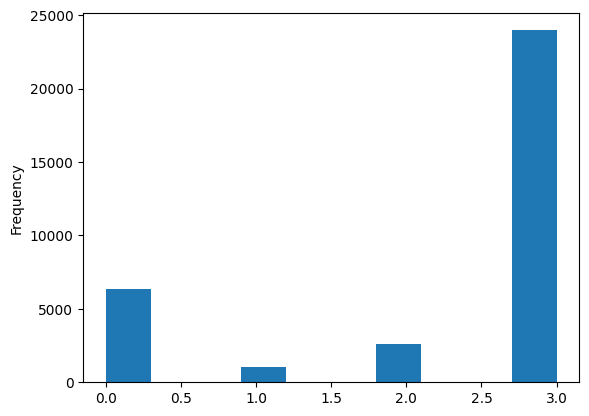

In [42]:
all_topics_df['multiple_labels'].apply(len).plot(kind='hist')

In [43]:
all_topics_df['primary_frame_resolved'] = [str(i)[:-2]+".0" if i is not None else None for i in all_topics_df['primary_frame'].values]

In [44]:
coverage = []
for i, row in all_topics_df.iterrows():
    if row['primary_frame_resolved']:
        if row['primary_frame_resolved'] in row['multiple_labels']:
            # Primary frame in multiple labels
            coverage.append(1)
        else:
            # Primary frame not in multiple labels
            coverage.append(0)
    else:
        # No primary frame
        coverage.append(-1)

In [45]:
# Num examples with primary frame not in majority labels
sum([i == 0 for i in coverage])

136

In [46]:
all_topics_df['clean_text'] = all_topics_df['text'].apply(lambda x: x[20:].replace("\n", " "))

In [47]:
all_topics_df['multiple_labels_names'] = all_topics_df['multiple_labels'].apply(lambda x: [frame_map[frame_code] for frame_code in x])

In [48]:
len(all_topics_df)

33967

In [50]:
all_topics_df_short = all_topics_df.dropna(subset=['primary_frame'])

In [56]:
sum(all_topics_df['primary_frame'].notna())

26854

In [51]:
len(all_topics_df_short)

26854

In [32]:
all_topics_df[['topic','clean_text','primary_frame_resolved','multiple_labels_names']].to_csv("../data/processed/mfc_multi_label.csv")

Misc comparison

In [33]:
temp_df = pd.read_csv("../data/processed/mfc_consolidated.csv")

In [35]:
print(len(temp_df), len(all_topics_df))

31210 26854
